# Predicting Gene Sequence Regenerative Contributions 

By: Jaeyoon Jung, Jeremy Milford, Shree Patel, Cynthia Perez

This notebook develops a model from one hot encoded gene sequences of the axolotl, norwegian rat, and zebrafish. This notebook uses one hot encoded and Fourier transformed data to build a CNN with an attention component. The model is further optimized with GridSearch. 

### Necessary Imports

In [1]:
# necessary imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Reshape, Conv1D, Layer, MaxPooling1D, MultiHeadAttention, Flatten, Input, concatenate, Attention, Flatten, TimeDistributed, BatchNormalization, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from onehot import onehote
from sklearn.metrics import roc_curve, auc
import torch
from RNA_tokenizer import extract_rna_sequences

2024-12-13 02:48:19.138795: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Skipping long sequence of length 16


In [2]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# tf.config.threading.set_intra_op_parallelism_threads(2)  
# tf.config.threading.set_inter_op_parallelism_threads(2)
# tf.config.set_visible_devices([], 'GPU')

In [3]:
features_df = pd.read_csv("gene_sequences.csv")
features_df.head()

,gene_name,sequence_length,gc_content,at_gc_ratio,kmer_3_GGG,kmer_3_GGC,kmer_3_GCG,kmer_3_CGG,kmer_3_GCT,kmer_3_CTG,...,kmer_3_TAG,kmer_3_CAN,kmer_3_ANN,kmer_3_NNN,kmer_3_NNT,kmer_3_NTA,organism,chromosome,regen,sequence
0,ADIPOQ,1487,0.465367,1.148844,0.014141,0.016162,0.005387,0.005387,0.013468,0.022896,...,0.008754,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,AGTR1A,2286,0.463255,1.158640,0.007881,0.018827,0.005692,0.004378,0.022329,0.029335,...,0.007881,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,AGTR2,2861,0.386928,1.584463,0.008395,0.010843,0.001399,0.001749,0.015390,0.023435,...,0.011193,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,AMTN,1032,0.465116,1.150000,0.011650,0.013592,0.001942,0.001942,0.014563,0.025243,...,0.005825,0.0,0.0,0.0,0.0,0.0,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,ARHGDIA,89866,0.470211,1.126704,0.016681,0.013810,0.006310,0.007344,0.015112,0.021421,...,0.011440,0.0,0.0,0.0,0.0,0.0,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


### Test, Train Split

In [4]:
# Drop gene_name and separate features and target 
X = features_df.drop(columns=['gene_name'])
y = (features_df['regen']).astype(int)  
y = y.to_numpy()

# Choose only numeric features for modeling
X_col = X.columns
print(X_col)
X_numeric_features = ["sequence_length", "gc_content", "at_gc_ratio", 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       'kmer_3_ATA', 'kmer_3_GTA', 'kmer_3_TAG', 'kmer_3_CAN', 'kmer_3_ANN',
       'kmer_3_NNN', 'kmer_3_NNT', 'kmer_3_NTA']

X = X.drop(columns = X_numeric_features)
X.head()

Index(['sequence_length', 'gc_content', 'at_gc_ratio', 'kmer_3_GGG',
       'kmer_3_GGC', 'kmer_3_GCG', 'kmer_3_CGG', 'kmer_3_GCT', 'kmer_3_CTG',
       'kmer_3_TGC', 'kmer_3_GCC', 'kmer_3_CCG', 'kmer_3_CGC', 'kmer_3_CCA',
       'kmer_3_CAG', 'kmer_3_AGC', 'kmer_3_CCC', 'kmer_3_CTA', 'kmer_3_TAA',
       'kmer_3_AAG', 'kmer_3_AGG', 'kmer_3_CTC', 'kmer_3_TCG', 'kmer_3_GGA',
       'kmer_3_GAG', 'kmer_3_AGA', 'kmer_3_TCT', 'kmer_3_TGT', 'kmer_3_GTT',
       'kmer_3_TTT', 'kmer_3_TTC', 'kmer_3_TCC', 'kmer_3_AGT', 'kmer_3_GTC',
       'kmer_3_GTG', 'kmer_3_TGG', 'kmer_3_CTT', 'kmer_3_TTA', 'kmer_3_AAA',
       'kmer_3_CAC', 'kmer_3_ACT', 'kmer_3_CGT', 'kmer_3_CAA', 'kmer_3_AAT',
       'kmer_3_ATG', 'kmer_3_TAT', 'kmer_3_TGA', 'kmer_3_GAC', 'kmer_3_ACA',
       'kmer_3_TCA', 'kmer_3_CCT', 'kmer_3_ACG', 'kmer_3_GAT', 'kmer_3_ATC',
       'kmer_3_CGA', 'kmer_3_CAT', 'kmer_3_TAC', 'kmer_3_AAC', 'kmer_3_GCA',
       'kmer_3_GAA', 'kmer_3_ACC', 'kmer_3_GGT', 'kmer_3_ATT', 'kmer_3_TTG',
       

,organism,chromosome,regen,sequence
0,Rattus norvegicus,2,0,CTCAGGAGACCTGGCGATTTTCTCTTCATTCCTGTCTGTACGAGTG...
1,Rattus norvegicus,2,0,CCGAGCCTGAGGGTTGGAACCTGCAGAGCAGCGACGCCCCCTAGGC...
2,Rattus norvegicus,2,0,CCAGAGTCTGGGGATGGAGCGAGCACAGAATTGAAAGCTTTCTTCA...
3,Rattus norvegicus,X2,1,AAAAGATAAATTTTGCACCAGAGTAAAGTGGAGAAGTCATCTGGAT...
4,Ambystoma mexicanum,3q,0,TTTCTAGAGCTCTCTTGTGGGACGGGAACTAGATAGACCGGAACTA...


In [5]:
# one hot encode each sequence and store in a NumPy array
# determine longest sequence
max_len = 34000

print(f"Max sequence length: {max_len}")

max_len_tokenized = 0

sequences_ohe = []
updated_Y = [] 
for i, seq in enumerate(X['sequence']):
    tokenized = extract_rna_sequences(seq)
    output = onehote(tokenized, max_len)
    if output is None:
        continue
    else:
        max_len_tokenized = max(max_len_tokenized, len(tokenized))
        sequences_ohe.append(output)
        updated_Y.append(y[i]) 
        
sequences_X_padded = pad_sequences(sequences_ohe, padding='post', maxlen = max_len_tokenized, dtype='float32', value=0)
# Replace the original Y_train with the updated one
Y = np.array(updated_Y)

print(max_len_tokenized)

Max sequence length: 34000
Skipping long sequence of length 49812
Skipping long sequence of length 203661
Skipping long sequence of length 508680
Skipping long sequence of length 227268
Skipping long sequence of length 93966
Skipping long sequence of length 53907
Skipping long sequence of length 992616
Skipping long sequence of length 188442
Skipping long sequence of length 162117
Skipping long sequence of length 43350
Skipping long sequence of length 183564
Skipping long sequence of length 498336
Skipping long sequence of length 108543
Skipping long sequence of length 435015
Skipping long sequence of length 158358
Skipping long sequence of length 105993
Skipping long sequence of length 379899
Skipping long sequence of length 113571
Skipping long sequence of length 91176
Skipping long sequence of length 182880
Skipping long sequence of length 130887
Skipping long sequence of length 98136
Skipping long sequence of length 1257951
Skipping long sequence of length 196143
Skipping long sequ

In [6]:
# fourier transform 

def apply_fourier_transform(padded_sequences):
    """
    Apply Fourier Transform along the sequence length for each channel.
    """
    # Perform Fourier Transform along the sequence length axis (axis=-1)
    fft_result = tf.signal.fft(padded_sequences)  

    magnitude_spectrum = tf.abs(fft_result) 
    return magnitude_spectrum

spectrum = apply_fourier_transform(sequences_X_padded)

num_frequencies = 50  # Retain only top 50 frequencies
reduced_spectrum = spectrum[:, :, :num_frequencies]

In [7]:
scaler = MinMaxScaler()

# Apply MinMaxScaler along the axes
normalized_spectrum = np.array([
    scaler.fit_transform(sample) for sample in reduced_spectrum
])

# train, test split
X_train, X_test, Y_train, Y_test = train_test_split(normalized_spectrum, Y, test_size=0.2, random_state=46)
print(len(X_train))

# Class Weights
class_0_count = np.sum(Y_train == 0)
class_1_count = np.sum(Y_train == 1)

class_weights = {0: (len(Y_train)) / class_0_count, 1: len(Y_train) / class_1_count}  # Inverse of class frequency

print("Class weights:", class_weights)

print(np.sum(Y_test == 0))
print(len(Y_test))


84
Class weights: {0: 2.1538461538461537, 1: 1.8666666666666667}
11
22


This train, test split has considered the sequences of the genes and has no additional information on the chromosome, organism, etc.

### CNN with Attention Mechanism

In [8]:
# Input layer
batch = 2
input_shape = (max_len_tokenized, 4)  
input_layer = Input(shape=input_shape)

# Block 1: Initial Convolution Layer
x = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.4)(x)

# Block 2: Deeper Convolution LAyer
x = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.4)(x)

# Add Attention Layer
query = Dense(32)(x)  # Transform `x` into query
key = Dense(32)(x)    # Transform `x` into key
value = Dense(32)(x)  # Transform `x` into value

x = Attention()([query, value, key])

# Flatten
x = GlobalMaxPooling1D()(x)  # Try GlobalMaxPooling1D() as an alternative

# Fully Connected Layers
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)

# Output Layer
output_layer = Dense(1, activation='sigmoid')(x)

# Model Creation
model = Model(inputs=input_layer, outputs=output_layer)

# Define learning rate reduction callback
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.5,          # Reduce learning rate by this factor
    patience=3,          # Wait for 'patience' epochs before reducing
    min_lr=1e-6          # Set a floor for the learning rate
)

early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=5,           # Number of epochs without improvement
    restore_best_weights=True  # Reverts to the best weights during training
)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with EarlyStopping
history = model.fit(
    X_train, Y_train,
    epochs=50,                 # Maximum number of epochs
    batch_size= batch,
    validation_data = (X_test, Y_test),
    class_weight = class_weights,
    callbacks=[lr_callback, early_stopping])  # Add the EarlyStopping callback here

# Summary
model.summary()

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.5187 - loss: 2.2435 - val_accuracy: 0.5000 - val_loss: 1.3147 - learning_rate: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5272 - loss: 1.9620 - val_accuracy: 0.5000 - val_loss: 1.1155 - learning_rate: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.4519 - loss: 1.7758 - val_accuracy: 0.5000 - val_loss: 0.9847 - learning_rate: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.4576 - loss: 1.6517 - val_accuracy: 0.5000 - val_loss: 0.8969 - learning_rate: 0.0010
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5506 - loss: 1.5815 - val_accuracy: 0.5000 - val_loss: 0.8385 - learning_rate: 0.0010
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3724 - loss: 1.5117 - val_accuracy: 0.5000 - val_loss: 0.7984 - learning_rate: 0.0010
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.3856 - loss: 1.4745 - val_accuracy: 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 23976, 4)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 23974, 64) │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 11987, 64) │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 11987, 64) │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 11987, 32) │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 11987, 32) │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 11987, 32) │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 11987, 32) │          0 │ dense[0][0],      │
│ (Attention)         │                   │            │ dense_2[0][0],    │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ attention[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      2,112 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │      2,080 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,893 (132.40 KB)

 Trainable params: 11,297 (44.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,596 (88.27 KB)

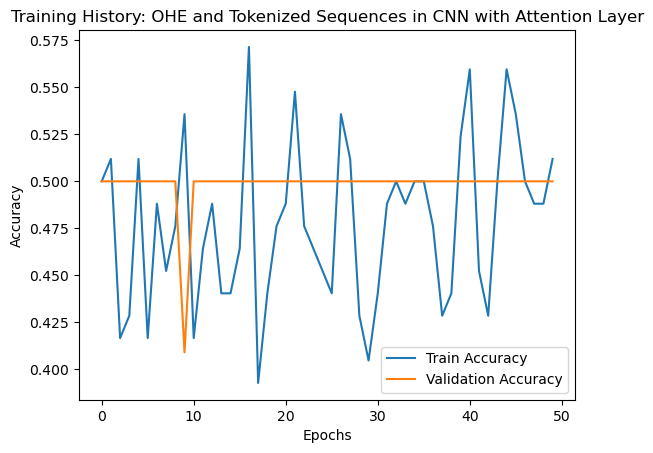

In [9]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: OHE and Tokenized Sequences in CNN with Attention Layer")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step


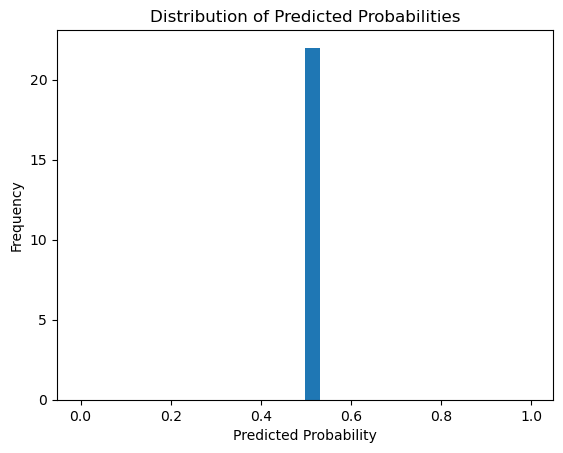

Predicted probabilities: [[0.49777597]
 [0.49777597]
 [0.49777597]
 [0.49777597]
 [0.49777597]
 [0.49777597]
 [0.49777597]
 [0.49777597]
 [0.49777597]
 [0.49777597]]


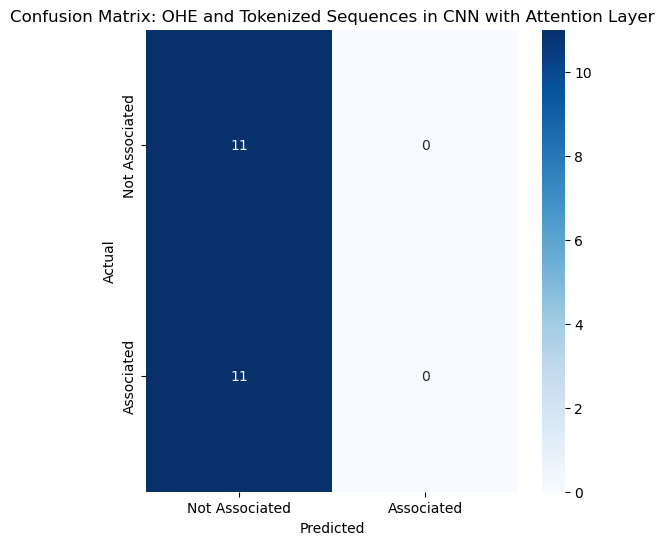

                precision    recall  f1-score   support

Not Associated       0.50      1.00      0.67        11
    Associated       0.00      0.00      0.00        11

      accuracy                           0.50        22
     macro avg       0.25      0.50      0.33        22
  weighted avg       0.25      0.50      0.33        22

Test Accuracy: 0.5


/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

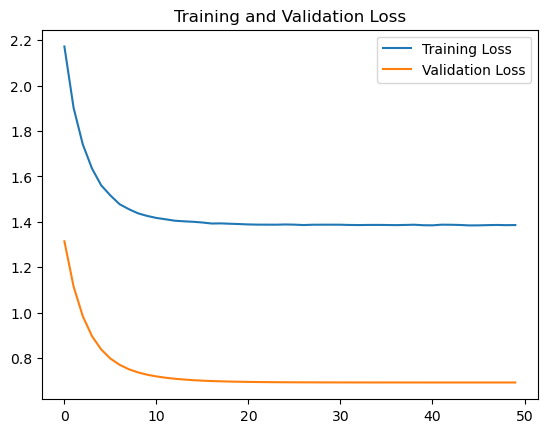

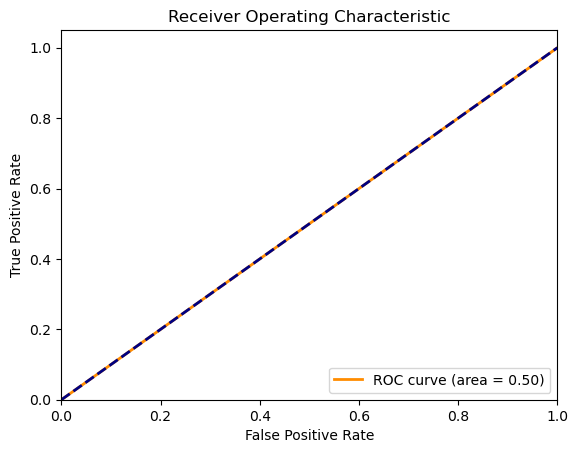

In [11]:
y_pred = model.predict(X_test, batch_size = 2)

# Plot the predicted probabilities
plt.hist(y_pred, bins=30)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

print("Predicted probabilities:", y_pred[:10])  # Check the first 10 predictions

threshold = 0.4982  # Adjust if needed ! 
y_pred_binary = (y_pred >= threshold).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: OHE and Tokenized Sequences in CNN with Attention Layer")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))

# Plot loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Replace `y_true` and `y_pred_prob` with your actual data

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


### SHAP Analysis

### Custom GridSearch

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class CustomKerasModel(BaseEstimator, ClassifierMixin):
    def __init__(self, filters_1=32, filters_2=16, kernel_size=3, dropout_rate=0.3, epochs=20, batch_size=8):
        self.filters_1 = filters_1
        self.filters_2 = filters_2
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        
    def build_model(self):
        input_shape = (max_len, 4)
        input_layer = Input(shape=input_shape)
        
        # Feature extraction layers
        x = Conv1D(filters=self.filters_1, kernel_size=self.kernel_size, kernel_regularizer=l2(0.01), activation='relu')(input_layer)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(self.dropout_rate)(x)

        x = Conv1D(filters=self.filters_2, kernel_size=self.kernel_size, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(self.dropout_rate)(x)

        # Attention layer
        query = Dense(32)(x)
        value = Dense(32)(x)
        key = Dense(32)(x)
        x = Attention()([query, value, key])

        # Flattening
        x = Flatten()(x)

        x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
        x = Dropout(self.dropout_rate)(x)
        x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
        output_layer = Dense(1, activation='sigmoid')(x)

        # Model creation
        model = Model(inputs=input_layer, outputs=output_layer)

        # Compile the model
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
        
        return model
    
    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]  # return accuracy

# Use the custom model for grid search
model = CustomKerasModel()

# Define the parameter grid for grid search
param_grid = {
    'batch_size': [4, 8],
    'filters_1': [32, 16], 
    'filters_2': [32, 16],
    'dropout_rate': [0.3, 0.4],
    'kernel_size': [3, 5],
    'epochs': [10, 20, 30]
}

# GridSearchCV with 3-fold cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', verbose=1, cv=3)

# Fit the grid search
grid_result = grid.fit(X_train, Y_train)

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best model to make predictions
best_model = grid_result.best_params_
# Create the model using the best parameters
model = model.build_model(filters_1 = best_model['filters_1'], filters_2 = best_model['filters_2'], 
        dropout_rate = best_model['dropout_rate'], kernel_size = best_model['kernel_size']) 

# Fit the model and get the history
history = model.fit(X_train, Y_train, epochs=best_model['epochs'], batch_size=best_model['batch_size'], validation_split=0.2)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History: STFT CNN/Attention w MaxLen 25000 GridSearch")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

cm = confusion_matrix(Y_test, y_pred_binary)
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Associated", "Associated"], yticklabels=["Not Associated", "Associated"])
plt.title("Confusion Matrix: STFT CNN/Attention w MaxLen 25000 GridSearch")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print(classification_report(Y_test, y_pred_binary, target_names=["Not Associated", "Associated"]))

print("Test Accuracy:", accuracy_score(Y_test, y_pred_binary))